# Facial Keypoint Detection

The main goal is to define and train a **Deep CNN** to perform facial keypoint detection by *regression*.
We use the  **68 keypoints** for a single face that captures facial features such as eyes, mouth and edges of face. Each point has its own (x,y) coordinates.
<img src='images/landmarks_numbered.jpg' width=30% height=30%/>


***

## Training data
There are two part of training data. THe image data are extracted from the [Youtube Face Dateset](https://www.cs.tau.ac.il/~wolf/ytfaces/), which includes the input images for the network. The labels of the training data come from the CSV file where the corresponding (x,y) labels are recorded.

There are **3462** images used for training, and **2308** images used for testing.

In [1]:
# import the required libraries
import glob
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [2]:
key_pts_frame = pd.read_csv('data/training_frames_keypoints.csv')

n = 55
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].as_matrix()
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: \n{}'.format(key_pts[:4]))

C:\Users\Project\Anaconda3\envs\Sylar_ML\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


Image name:  Tim_Pawlenty_01.jpg
Landmarks shape:  (68, 2)
First 4 key pts: 
[[ 60.  82.]
 [ 58.  89.]
 [ 58.  97.]
 [ 60. 104.]]


In [3]:
# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


## An image preview
Use `show_keypoints` to display image with its *keypoints*. Note that these images are not of the same size, so they need to be `resize()` later.

In [4]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

C:\Users\Project\Anaconda3\envs\Sylar_ML\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Picabo_Street_22.jpg


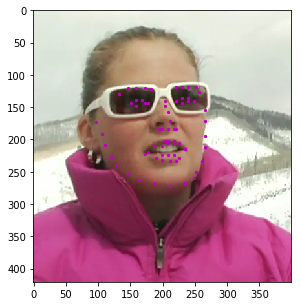

In [5]:
# Display a few different types of images by changing the index n

# select an image by index in our data frame
n = 60
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].as_matrix()
key_pts = key_pts.astype('float').reshape(-1, 2)

print(image_name)
plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('data/training/', image_name)), key_pts)
plt.show()

## Construct dataset and transformations
Construct our data into `torch.utils.data.Dataset` class.
Overwrite the `__len__` and `__getietm__` function.

The CSV file are read in `__init__`, however, the images are only retrieved with `__getitem__` so that it doesn't occupy the memory when unneccessary.

In [6]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):
    """Face keypoint dataset"""
    def __init__(self, csv_path, root_dir, transform=None):
        """
        Args:
            csv_path (string): Path to the csv file with annotations.
            root_dir (string): Director with all the images.
            transform (callable, option): Optional transdorm to be applied on a sample
        """
        self.key_pts_frame = pd.read_csv(csv_path)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.key_pts_frame)
    
    def __getitem__(self, idx):
        image_name = self.key_pts_frame.iloc[idx,0]
        image_name_path = os.path.join(self.root_dir,image_name)
        
        image = mpimg.imread(image_name_path)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx,1:].as_matrix()
        key_pts = key_pts.astype('float').reshape(-1,2) # reshape to represent (x,y) coordinates
        sample = {'image': image, 'keypoints': key_pts, 'name':image_name}
        
        if self.transform:  # if transform(s) specified, then perform them
            sample = self.transform(sample)
            
        return sample

In [7]:
# Construct the dataset
face_dataset = FacialKeypointsDataset(csv_path='data/training_frames_keypoints.csv',
                                      root_dir='data/training/')

# print some stats about the dataset
print('Length of dataset:', len(face_dataset))
print('The elements in each data set:', face_dataset[0].keys())

Length of dataset: 3462


C:\Users\Project\Anaconda3\envs\Sylar_ML\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


The elements in each data set: dict_keys(['image', 'keypoints', 'name'])


C:\Users\Project\Anaconda3\envs\Sylar_ML\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


0 (154, 153, 3) (68, 2)
1 (139, 138, 3) (68, 2)
2 (191, 184, 3) (68, 2)


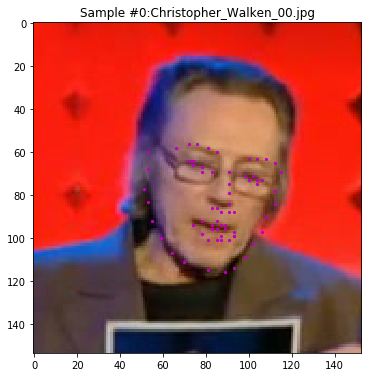

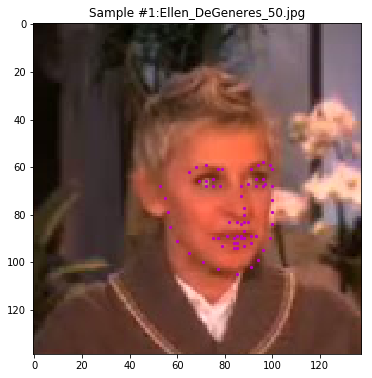

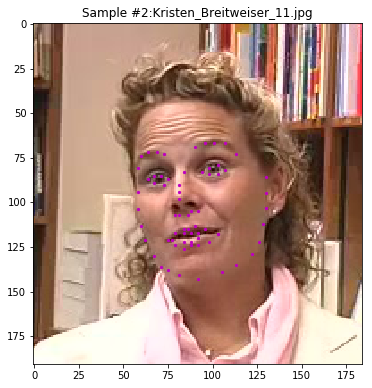

In [8]:
# Display a few of the images from the dataset
num_to_display = 3

for i in range(num_to_display):
    
    # define the size of images
    fig = plt.figure(figsize=(20,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    # print the shape of the image and keypoints
    print(i, sample['image'].shape, sample['keypoints'].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}:{}'.format(i,sample['name']))
    
    # Using the same display function, defined earlier
    show_keypoints(sample['image'], sample['keypoints'])


## Transformations

Use *transforms* from `data_load.py` because our dataset doesn't just have images, special process need to be done to the **keypoints** and take care of the dataset as a dictionary.

**Note:** `Rescale, RandomCrop, Normalize, ToTensor` from `data_load.py` is different that what we nornally import from torchvision

In [9]:
from torchvision.transforms import Compose
from data_load import Rescale, RandomCrop, Normalize, ToTensor

data_transform = Compose([Rescale(250), # rescale both image size and keypoint coordinates
                          RandomCrop(224), # randomly crop out 224x224 pixels
                          Normalize(), # This would convert the image to grayscale first. 
                                       # Color channel to [0,1]. 
                                       # keypoint channel standardize mean = 100, std = 50
                          ToTensor()])

### Create the transformed dataset

In [10]:
transformed_dataset = FacialKeypointsDataset(csv_path='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)
print("Number of images:", len(transformed_dataset))

n = 55
sample = transformed_dataset[n]

print(sample['image'].size(), sample['keypoints'].size())

Number of images: 3462


C:\Users\Project\Anaconda3\envs\Sylar_ML\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


torch.Size([3, 224, 224]) torch.Size([68, 2])


### Batching and loading data
Create the dataloader and determine the `batch_size`
* Too small batch size cause loss to fluctuate.
* Too large batch size cause slow training and possibly run out of memory.
* This is one of the hyper-parameter we can test out through iterations.

**Note that for Windows Users**: set the `num_workers` to 0

In [11]:
# load training data in batches
batch_size = 64

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Create the model
Here we consider <span style="color:red">**two CNN models**</span>.
### model version 1 is a self-designed CNN
This model is a **modified** implementation of the [Orginal Paper](https://arxiv.org/pdf/1710.00977.pdf).
It has **5** Conv2d layers and **3** fully-connected layers. Batch normalization and dropout layers are implemented for both Conv2d and Dense layer.(*adding dropout layer to Conv2d is not very trendy nowadays*)

The CNN model is defined in the `models.py` file

### model version 2 is the famous ResNet 50
We import the **ResNet50** architecture from `torchvision.models`. Also, download the pre-trained weights and freeze these layers so that they will not be trained later.
Lastly, remove the top layer(the classifier) and replace it with our desired output.

In [12]:
# enable GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
torch.cuda.get_device_name(0)

cuda


'GeForce GTX 1080 Ti'

In [13]:
# This imports a self-designed CNN model from the 'models.py' file

from models import Net
model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (dropout1): Dropout2d(p=0.1)
  (dropout2): Dropout2d(p=0.2)
  (dropout3): Dropout2d(p=0.3)
  (dropout4): Dropout2d(p=0.4)
  (dropout5): Dropout2d(p=0.5)
  (dropout6): Dropout(p=0.5)
  (dropout7): Dropout(p=0.6)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=136, bias=True)
  (BF1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BF2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BF3): BatchNorm2d

In [14]:
from torchvision import models
model_Res = models.resnet50(pretrained=True)
model_Res

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [15]:
from torch import nn
# Freeze parameters so we don't backprop through them
for param in model_Res.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(2048,512)),
                            ('relu', nn.ReLU()),
                            ('dropout', nn.Dropout(p=0.5)),
                            ('fc2', nn.Linear(512, 136))
                            ]))
model_Res.fc = classifier
model = model_Res.to(device)

## Test dataset
Construct our test dataset and visualize the keypoint predictions before any tranining is done

In [16]:
# Create test dataset and perform the same transforms
test_dataset = FacialKeypointsDataset(csv_path='data/test_frames_keypoints.csv',
                                      root_dir='data/test/',
                                      transform=data_transform)

In [17]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

### Apply the model on a test sample
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

In [18]:
def model_sample_output():
    for i, sample in enumerate(test_loader):
        # decomposition 
        images, key_pts = sample['image'], sample['keypoints'].to(device)
        
        # conver images to FloatTensors
        images = images.type(torch.FloatTensor).to(device)
        
        # forward pass to get output
        model.eval()
        output_pts = model(images)
        
        # reshape to [batch_size,68,2]
        output_pts = output_pts.view(output_pts.size()[0], 68,-1)
        
        # break after first image is tested
        if i ==0:
            return images, output_pts, key_pts

In [19]:
test_images, test_outputs, gt_pts = model_sample_output()

# print out the dimensions of the data to see if they make sense
print(f'Batch images size:{test_images.data.size()}')
print({f"Network output size:{test_outputs.data.size()}"})
print(f"Input keypoint size:{gt_pts.size()}")

C:\Users\Project\Anaconda3\envs\Sylar_ML\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Batch images size:torch.Size([10, 3, 224, 224])
{'Network output size:torch.Size([10, 68, 2])'}
Input keypoint size:torch.Size([10, 68, 2])


### Visualize predicted keypoints before any training

In [20]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
#     plt.imshow(image, cmap="gray")
    plt.imshow(image)
    plt.scatter(predicted_key_pts[:,0], predicted_key_pts[:,1], s=20, marker='.', c='r')
    
    # plot ground truth label in green
    if gt_pts is not None:
        plt.scatter(gt_pts[:,0], gt_pts[:,1], s=20, marker='.', c='g')

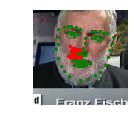

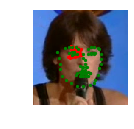

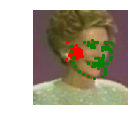

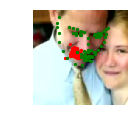

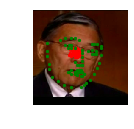

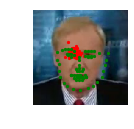

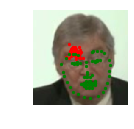

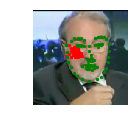

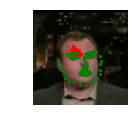

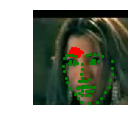

In [21]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=batch_size):
    for i in range(batch_size):
        plt.figure(figsize=(20,20))
        ax = plt.subplot(1, batch_size, i+1)
        
        # un-transform the image data
        image = test_images[i].data.cpu()   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
        
        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data.cpu()
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i].cpu()         
            ground_truth_pts = ground_truth_pts*50.0+100
            
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

# Start training
### Define loss and optimizer

In [50]:
import torch.optim as optim
import torch.nn as nn

# we use Smooth L1 Loss here because it's less sensitive to outliers than the MSELoss 
# and in some cases prevents exploding gradients
criterion = nn.SmoothL1Loss()

# we would change lr after training for certain epochs
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Training model

In [38]:
def train_model(n_epochs):
    # switch model to training mode (this enables dropout and track tensor gradients)
    model.train()
    loss_log =[]
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        
        
        for batch_i, data in enumerate(train_loader):
            # decomposition
            images = data['image']
            key_pts = data['keypoints']
            
            # flatten ground truth keypoints for loss calculation later
            key_pts = key_pts.view(key_pts.size(0), -1) 
            
            # convert variable to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor).to(device)
            images = images.type(torch.FloatTensor).to(device)
            
            # forward pass, calculate loss, zero the gradient, back-propagation, update the weights
            output = model(images)
            loss = criterion(output, key_pts)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # print loss statistics
            running_loss += loss.item()  # .item() retrieve the one value in the loss
            if batch_i % 10 == 9: # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                loss_log.append(running_loss)
                running_loss = 0.0

    print('Finished Training')
    return loss_log

In [39]:
n_epochs = 500
loss_log = train_model(n_epochs)

C:\Users\Project\Anaconda3\envs\Sylar_ML\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 1, Batch: 10, Avg. Loss: 0.02602477613836527
Epoch: 1, Batch: 20, Avg. Loss: 0.024611598625779153
Epoch: 1, Batch: 30, Avg. Loss: 0.024366242066025733
Epoch: 1, Batch: 40, Avg. Loss: 0.03126809541136026
Epoch: 1, Batch: 50, Avg. Loss: 0.024989596381783486
Epoch: 2, Batch: 10, Avg. Loss: 0.02925360556691885
Epoch: 2, Batch: 20, Avg. Loss: 0.024676835164427757
Epoch: 2, Batch: 30, Avg. Loss: 0.02542793657630682
Epoch: 2, Batch: 40, Avg. Loss: 0.02323878463357687
Epoch: 2, Batch: 50, Avg. Loss: 0.026782756485044957
Epoch: 3, Batch: 10, Avg. Loss: 0.02456320747733116
Epoch: 3, Batch: 20, Avg. Loss: 0.02591777630150318
Epoch: 3, Batch: 30, Avg. Loss: 0.025695283152163028
Epoch: 3, Batch: 40, Avg. Loss: 0.02827672641724348
Epoch: 3, Batch: 50, Avg. Loss: 0.02297108620405197
Epoch: 4, Batch: 10, Avg. Loss: 0.023589228093624116
Epoch: 4, Batch: 20, Avg. Loss: 0.024360714107751848
Epoch: 4, Batch: 30, Avg. Loss: 0.025212156400084496
Epoch: 4, Batch: 40, Avg. Loss: 0.024736340157687664
Ep

Epoch: 62, Batch: 20, Avg. Loss: 0.026074584014713763
Epoch: 62, Batch: 30, Avg. Loss: 0.02530998904258013
Epoch: 62, Batch: 40, Avg. Loss: 0.023875905200839043
Epoch: 62, Batch: 50, Avg. Loss: 0.025378749147057532
Epoch: 63, Batch: 10, Avg. Loss: 0.025107220374047758
Epoch: 63, Batch: 20, Avg. Loss: 0.027463073283433913
Epoch: 63, Batch: 30, Avg. Loss: 0.0269340418279171
Epoch: 63, Batch: 40, Avg. Loss: 0.02555793933570385
Epoch: 63, Batch: 50, Avg. Loss: 0.025329400412738325
Epoch: 64, Batch: 10, Avg. Loss: 0.025104743242263795
Epoch: 64, Batch: 20, Avg. Loss: 0.0252632562071085
Epoch: 64, Batch: 30, Avg. Loss: 0.02641610223799944
Epoch: 64, Batch: 40, Avg. Loss: 0.025762918777763842
Epoch: 64, Batch: 50, Avg. Loss: 0.025363124348223208
Epoch: 65, Batch: 10, Avg. Loss: 0.02611557636409998
Epoch: 65, Batch: 20, Avg. Loss: 0.025474499724805356
Epoch: 65, Batch: 30, Avg. Loss: 0.029166105017066003
Epoch: 65, Batch: 40, Avg. Loss: 0.024837769754230975
Epoch: 65, Batch: 50, Avg. Loss: 0.0

Epoch: 122, Batch: 40, Avg. Loss: 0.027642196230590343
Epoch: 122, Batch: 50, Avg. Loss: 0.024284925311803818
Epoch: 123, Batch: 10, Avg. Loss: 0.026971086114645004
Epoch: 123, Batch: 20, Avg. Loss: 0.02503366507589817
Epoch: 123, Batch: 30, Avg. Loss: 0.022950276732444763
Epoch: 123, Batch: 40, Avg. Loss: 0.025098520144820214
Epoch: 123, Batch: 50, Avg. Loss: 0.0237921092659235
Epoch: 124, Batch: 10, Avg. Loss: 0.02712590992450714
Epoch: 124, Batch: 20, Avg. Loss: 0.024171282164752485
Epoch: 124, Batch: 30, Avg. Loss: 0.024956021830439566
Epoch: 124, Batch: 40, Avg. Loss: 0.02506041508167982
Epoch: 124, Batch: 50, Avg. Loss: 0.02426400613039732
Epoch: 125, Batch: 10, Avg. Loss: 0.025039657950401306
Epoch: 125, Batch: 20, Avg. Loss: 0.027363606356084348
Epoch: 125, Batch: 30, Avg. Loss: 0.027364311926066875
Epoch: 125, Batch: 40, Avg. Loss: 0.025391598418354987
Epoch: 125, Batch: 50, Avg. Loss: 0.025192377157509327
Epoch: 126, Batch: 10, Avg. Loss: 0.02443365063518286
Epoch: 126, Batch

Epoch: 182, Batch: 30, Avg. Loss: 0.025921132974326612
Epoch: 182, Batch: 40, Avg. Loss: 0.026318282447755338
Epoch: 182, Batch: 50, Avg. Loss: 0.02366984486579895
Epoch: 183, Batch: 10, Avg. Loss: 0.023830752447247507
Epoch: 183, Batch: 20, Avg. Loss: 0.025934090837836266
Epoch: 183, Batch: 30, Avg. Loss: 0.024664279818534852
Epoch: 183, Batch: 40, Avg. Loss: 0.02505499720573425
Epoch: 183, Batch: 50, Avg. Loss: 0.02560749091207981
Epoch: 184, Batch: 10, Avg. Loss: 0.030406940169632433
Epoch: 184, Batch: 20, Avg. Loss: 0.024709808453917504
Epoch: 184, Batch: 30, Avg. Loss: 0.024846169538795947
Epoch: 184, Batch: 40, Avg. Loss: 0.022425403445959093
Epoch: 184, Batch: 50, Avg. Loss: 0.025248602963984013
Epoch: 185, Batch: 10, Avg. Loss: 0.02771660778671503
Epoch: 185, Batch: 20, Avg. Loss: 0.024869688041508197
Epoch: 185, Batch: 30, Avg. Loss: 0.025597254373133184
Epoch: 185, Batch: 40, Avg. Loss: 0.023913988657295705
Epoch: 185, Batch: 50, Avg. Loss: 0.023983663506805898
Epoch: 186, Ba

Epoch: 242, Batch: 30, Avg. Loss: 0.02440490797162056
Epoch: 242, Batch: 40, Avg. Loss: 0.02435923870652914
Epoch: 242, Batch: 50, Avg. Loss: 0.024891302362084387
Epoch: 243, Batch: 10, Avg. Loss: 0.023897936195135118
Epoch: 243, Batch: 20, Avg. Loss: 0.027904911525547506
Epoch: 243, Batch: 30, Avg. Loss: 0.027542222291231155
Epoch: 243, Batch: 40, Avg. Loss: 0.024712244793772698
Epoch: 243, Batch: 50, Avg. Loss: 0.027383950538933277
Epoch: 244, Batch: 10, Avg. Loss: 0.027752297185361385
Epoch: 244, Batch: 20, Avg. Loss: 0.024313932098448277
Epoch: 244, Batch: 30, Avg. Loss: 0.024426266178488733
Epoch: 244, Batch: 40, Avg. Loss: 0.024745607934892177
Epoch: 244, Batch: 50, Avg. Loss: 0.02360190488398075
Epoch: 245, Batch: 10, Avg. Loss: 0.024045434035360812
Epoch: 245, Batch: 20, Avg. Loss: 0.026208042167127132
Epoch: 245, Batch: 30, Avg. Loss: 0.024857759289443494
Epoch: 245, Batch: 40, Avg. Loss: 0.026785704120993615
Epoch: 245, Batch: 50, Avg. Loss: 0.02382464483380318
Epoch: 246, Ba

Epoch: 302, Batch: 20, Avg. Loss: 0.024262543022632598
Epoch: 302, Batch: 30, Avg. Loss: 0.023612872883677482
Epoch: 302, Batch: 40, Avg. Loss: 0.02960812281817198
Epoch: 302, Batch: 50, Avg. Loss: 0.02539835460484028
Epoch: 303, Batch: 10, Avg. Loss: 0.025133166834712027
Epoch: 303, Batch: 20, Avg. Loss: 0.0269226485863328
Epoch: 303, Batch: 30, Avg. Loss: 0.02365271970629692
Epoch: 303, Batch: 40, Avg. Loss: 0.026195388101041318
Epoch: 303, Batch: 50, Avg. Loss: 0.028542220965027808
Epoch: 304, Batch: 10, Avg. Loss: 0.025440691411495207
Epoch: 304, Batch: 20, Avg. Loss: 0.026557546108961105
Epoch: 304, Batch: 30, Avg. Loss: 0.025382458232343197
Epoch: 304, Batch: 40, Avg. Loss: 0.02461942695081234
Epoch: 304, Batch: 50, Avg. Loss: 0.02451333198696375
Epoch: 305, Batch: 10, Avg. Loss: 0.02733757272362709
Epoch: 305, Batch: 20, Avg. Loss: 0.02544811386615038
Epoch: 305, Batch: 30, Avg. Loss: 0.025983846746385098
Epoch: 305, Batch: 40, Avg. Loss: 0.02471296563744545
Epoch: 305, Batch: 5

Epoch: 362, Batch: 10, Avg. Loss: 0.02378566898405552
Epoch: 362, Batch: 20, Avg. Loss: 0.02620103321969509
Epoch: 362, Batch: 30, Avg. Loss: 0.025597303360700607
Epoch: 362, Batch: 40, Avg. Loss: 0.02572253327816725
Epoch: 362, Batch: 50, Avg. Loss: 0.026707626320421694
Epoch: 363, Batch: 10, Avg. Loss: 0.02533155269920826
Epoch: 363, Batch: 20, Avg. Loss: 0.02521463520824909
Epoch: 363, Batch: 30, Avg. Loss: 0.02919715512543917
Epoch: 363, Batch: 40, Avg. Loss: 0.023626209795475007
Epoch: 363, Batch: 50, Avg. Loss: 0.026110510900616647
Epoch: 364, Batch: 10, Avg. Loss: 0.023926031589508057
Epoch: 364, Batch: 20, Avg. Loss: 0.024993663467466832
Epoch: 364, Batch: 30, Avg. Loss: 0.024073488265275955
Epoch: 364, Batch: 40, Avg. Loss: 0.026048816181719302
Epoch: 364, Batch: 50, Avg. Loss: 0.026018536277115346
Epoch: 365, Batch: 10, Avg. Loss: 0.027412100695073605
Epoch: 365, Batch: 20, Avg. Loss: 0.024371476285159586
Epoch: 365, Batch: 30, Avg. Loss: 0.022496568225324153
Epoch: 365, Batc

Epoch: 422, Batch: 10, Avg. Loss: 0.02352146841585636
Epoch: 422, Batch: 20, Avg. Loss: 0.025561918318271638
Epoch: 422, Batch: 30, Avg. Loss: 0.025309608317911625
Epoch: 422, Batch: 40, Avg. Loss: 0.023796020448207854
Epoch: 422, Batch: 50, Avg. Loss: 0.02719381432980299
Epoch: 423, Batch: 10, Avg. Loss: 0.024086892791092395
Epoch: 423, Batch: 20, Avg. Loss: 0.027136651612818242
Epoch: 423, Batch: 30, Avg. Loss: 0.024148357659578325
Epoch: 423, Batch: 40, Avg. Loss: 0.02775665633380413
Epoch: 423, Batch: 50, Avg. Loss: 0.026260764710605143
Epoch: 424, Batch: 10, Avg. Loss: 0.02437860853970051
Epoch: 424, Batch: 20, Avg. Loss: 0.02402945701032877
Epoch: 424, Batch: 30, Avg. Loss: 0.027992462553083897
Epoch: 424, Batch: 40, Avg. Loss: 0.023286565393209457
Epoch: 424, Batch: 50, Avg. Loss: 0.02956277970224619
Epoch: 425, Batch: 10, Avg. Loss: 0.02376812193542719
Epoch: 425, Batch: 20, Avg. Loss: 0.025720617547631264
Epoch: 425, Batch: 30, Avg. Loss: 0.0259297588840127
Epoch: 425, Batch: 

Epoch: 482, Batch: 10, Avg. Loss: 0.02349160760641098
Epoch: 482, Batch: 20, Avg. Loss: 0.026180917955935003
Epoch: 482, Batch: 30, Avg. Loss: 0.02318934239447117
Epoch: 482, Batch: 40, Avg. Loss: 0.02552889324724674
Epoch: 482, Batch: 50, Avg. Loss: 0.02465979102998972
Epoch: 483, Batch: 10, Avg. Loss: 0.02544009331613779
Epoch: 483, Batch: 20, Avg. Loss: 0.027760723046958445
Epoch: 483, Batch: 30, Avg. Loss: 0.02780722379684448
Epoch: 483, Batch: 40, Avg. Loss: 0.024388884007930756
Epoch: 483, Batch: 50, Avg. Loss: 0.02495772633701563
Epoch: 484, Batch: 10, Avg. Loss: 0.023075402341783048
Epoch: 484, Batch: 20, Avg. Loss: 0.023703422769904135
Epoch: 484, Batch: 30, Avg. Loss: 0.025433613173663615
Epoch: 484, Batch: 40, Avg. Loss: 0.02506860941648483
Epoch: 484, Batch: 50, Avg. Loss: 0.02724941335618496
Epoch: 485, Batch: 10, Avg. Loss: 0.030400976538658142
Epoch: 485, Batch: 20, Avg. Loss: 0.02365620881319046
Epoch: 485, Batch: 30, Avg. Loss: 0.025639856420457362
Epoch: 485, Batch: 4

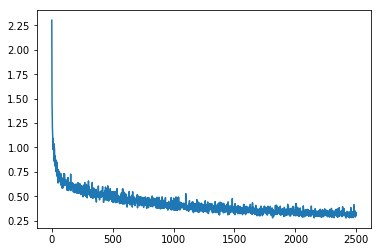

In [27]:
plt.plot(loss_log)
plt.show()

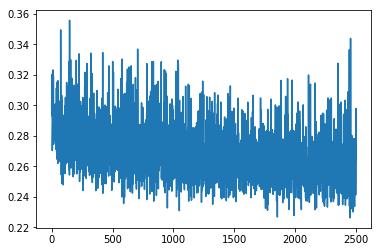

In [31]:
plt.plot(loss_log)
plt.show()

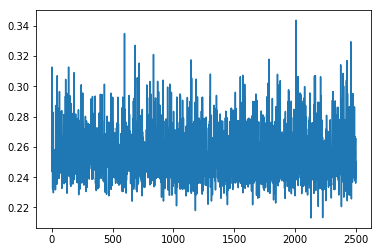

In [40]:
plt.plot(loss_log)
plt.show()

## Training log
* **First run**(batchsize = 64, lr=0.0001): 500 epoches, *start*: 0.230; *end*: 0.031
* **Second run**(batchsize = 64, lr=0.00001): 500 epoches, *start*: 0.032; *end*: 0.026
* **Third run**(batchsize = 64, lr=0.000002): 500 epoches, *start*: 0.024; *end*: 0.023

In [55]:
# get a sample of test data again
test_images, test_outputs, gt_pts = model_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

C:\Users\Project\Anaconda3\envs\Sylar_ML\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


torch.Size([10, 3, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


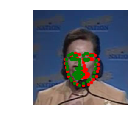

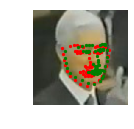

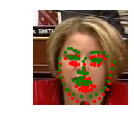

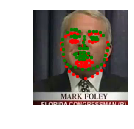

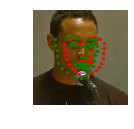

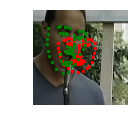

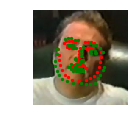

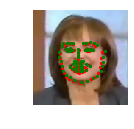

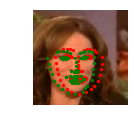

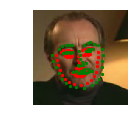

In [56]:
visualize_output(test_images, test_outputs, gt_pts)

In [41]:
model_dir = 'saved_models/'
model_name = 'keypoints_model_transferRes50_3.pt'

In [42]:
torch.save(model.state_dict(), model_dir+model_name)

In [ ]:
model.load_state_dict(torch.load(model_dir+model_name))